In [1]:
!rm *00*

In [2]:
%matplotlib ipympl

# Standard library
import glob
import sys
import os

# Third-party.
import matplotlib.pyplot as plt
import colormaps as cmaps
import numpy as np
from datetime import datetime
import ls2d
import cartopy.crs as ccrs
import nest_asyncio
from numba import jit

# Local library
from microhhpy.spatial import Domain, plot_domains
from microhhpy.real import create_input_from_regular_latlon
from microhhpy.thermo import calc_moist_basestate
from microhhpy.solvers import solve_pressure_dct, calc_divergence, make_divergence_free_dct
from microhhpy.spatial import calc_vertical_grid_2nd

TF = np.float64

# Needed to use asyncio with Jupyter notebooks.``
nest_asyncio.apply()

In [3]:
#lon = 108.75
#lat = 11.25
#
#settings = {
#    'start_date'  : datetime(year=2021, month=3, day=4, hour=0),
#    'end_date'    : datetime(year=2021, month=3, day=4, hour=1),
#    'central_lon' : lon,
#    'central_lat' : lat,
#    'area_size'   : 3,
#    'case_name'   : 'vinh_tan',
#    'era5_path'   : '/home/scratch1/bart/LS2D_ERA5/',
#    'era5_expver' : 1,
#    'cdsapirc'    : '/home/bart/.cdsapirc_ads'
#    }

lon = 4.92
lat = 51.97

settings = {
    'start_date'  : datetime(year=2022, month=5, day=1, hour=12),
    'end_date'    : datetime(year=2022, month=5, day=1, hour=13),
    'central_lon' : lon,
    'central_lat' : lat,
    'area_size'   : 3,
    'case_name'   : 'slocs_rf',
    'era5_path'   : '/home/scratch1/bart/LS2D_ERA5/',
    'era5_expver' : 1,
    'cdsapirc'    : '/home/bart/.cdsapirc_ads'
    }

era5 = ls2d.Read_era5(settings)
era5.calculate_forcings(n_av=3, method='2nd')

Reading ERA5 from 2022-05-01 12:00:00 to 2022-05-01 13:00:00 [21-10: 11:51]
Calculating large-scale forcings [21-10: 11:51]
 - Using nearest lat/lon = 51.97/4.92 (requested = 51.97/4.92), distance ~= 0.0 km
 - Averaging ERA5 over a 1.75°×1.75° spatial area.
 - Selected grid point is over land.


In [4]:
proj_str = f'+proj=lcc +lat_1={lat-1} +lat_2={lat+1} +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs'

dom0 = Domain(
    xsize=172_800,
    ysize=172_800,
    itot=128,
    jtot=128,
    n_ghost=1,
    n_sponge=5,
    lon=lon,
    lat=lat,
    anchor='center',
    proj_str=proj_str)

#plot_domains([dom0], use_projection=True)

In [5]:
# Vertical grid.
zsize = 3200
ktot = 128
dz = zsize / ktot
z = np.arange(dz/2, zsize, dz)

gd = calc_vertical_grid_2nd(z, zsize)

In [6]:
# Base state from mean ERA5 fields.
les_input = era5.get_les_input(z)

bs = calc_moist_basestate(
    les_input['thl'][0,:].values,
    les_input['qt'][0,:].values,
    float(les_input['ps'][0].values),
    z,
    zsize,
    dtype=TF)

In [7]:
# Short-cuts!
xsize = dom0.xsize
ysize = dom0.ysize

dx = dom0.dx
dy = dom0.dy

dxi = 1/dx
dyi = 1/dy

rho = bs['rho']
rhoh = bs['rhoh']

z = gd['z']
zh = gd['zh']

dz = gd['dz']
dzi = gd['dzi']
dzhi = gd['dzhi']

In [8]:
fields_era = {
    'u': era5.u[:,:,:,:],
    'v': era5.v[:,:,:,:],
    'w': era5.wls[:,:,:,:],
    'thl': era5.thl[:,:,:,:],
    'qt': era5.qt[:,:,:,:],
}

# Gaussian filter size (m) of filter after interpolation.
sigma_h = 5_000

# 3D buffer.
zstart_buffer = 0.75 * zsize

ds = create_input_from_regular_latlon(
    fields_era,
    era5.lons.data,   # Strip off array masks.
    era5.lats.data,
    era5.z[:,:,:,:],
    era5.p[:,:,:,:],
    era5.time_sec,
    z,
    zsize,
    zstart_buffer,
    bs['rho'],
    bs['rhoh'],
    dom0,
    sigma_h,
    perturb_size=4,
    perturb_amplitude={'thl': 0.1, 'qt':0.1e-3},
    perturb_max_height=1000,
    clip_at_zero=['qt'],
    name_suffix='era5',
    output_dir='.',
    ntasks=16,
    float_type=TF)

[2025/10/21 11:51:29] [microhhpy] [INFO] Creating MicroHH input in ..'
[2025/10/21 11:51:30] [microhhpy] [INFO] Using Gaussian filter with sigma = 4 grid cells'
[2025/10/21 11:51:30] [microhhpy] [DEBUG] Processing momentum at t=0.'
[2025/10/21 11:51:30] [microhhpy] [DEBUG] Processing momentum at t=3600.'
[2025/10/21 11:51:34] [microhhpy] [DEBUG] Velocity corrections: mean duv/dxy=5.661812843606078e-06 m/s/km'
[2025/10/21 11:51:35] [microhhpy] [DEBUG] Velocity corrections: mean duv/dxy=9.771703637909414e-05 m/s/km'


DEBUG: saving non-fixed velocity fields...


[2025/10/21 11:51:35] [microhhpy] [DEBUG] Maximum divergence in LES domain: 4.253e-19 at i=36, j=123, k=28'
[2025/10/21 11:51:35] [microhhpy] [DEBUG] Maximum divergence in LES domain: 4.309e-19 at i=43, j=108, k=33'
[2025/10/21 11:51:35] [microhhpy] [INFO] Created momentum input in 0:00:05.045288.'


In [9]:
# Raw files, interpolated from ERA5, no correction.
u0_raw = np.fromfile('u0.0000000', dtype=TF).reshape((ktot, dom0.jtot+4, dom0.itot+4))
v0_raw = np.fromfile('v0.0000000', dtype=TF).reshape((ktot, dom0.jtot+4, dom0.itot+4))
w0_raw = np.fromfile('w0.0000000', dtype=TF).reshape((ktot+1, dom0.jtot+4, dom0.itot+4))

# Slice out interior but keep one ghost cell for u,v,w.
u0 = u0_raw[:, 2:-2, 2:-1]
v0 = v0_raw[:, 2:-1, 2:-2]
w0 = w0_raw[:, 2:-2, 2:-2]

u1 = u0.copy()
v1 = v0.copy()
w1 = w0.copy()

make_divergence_free_dct(u1, v1, w1, rho, rhoh, dx, dy, dz, dzi, dzhi, solve_w=False, float_type=TF)

[2025/10/21 11:51:36] [microhhpy] [DEBUG] Mass inbalance in = 9.3e+06 kg/s, out = 1.1e-06 kg/s, max div. = 6.35690130808657e-17 kg/m3/s @ i=37, j=14, k=68'


In [10]:
# Corrected fields (old method...)
u2 = np.fromfile('u_era5.0000000', dtype=TF).reshape((ktot, dom0.jtot, dom0.itot))
v2 = np.fromfile('v_era5.0000000', dtype=TF).reshape((ktot, dom0.jtot, dom0.itot))
w2 = np.fromfile('w_era5.0000000', dtype=TF).reshape((ktot, dom0.jtot, dom0.itot))

In [11]:
# pfff
u00 = u0_raw[:,2:-2, 2:-2]
v00 = v0_raw[:,2:-2, 2:-2]
w00 = w0_raw[:-1,2:-2, 2:-2]

u11 = u1[:,:,:-1]
v11 = v1[:,:-1,:]
w11 = w1[:-1,:,:]

u22 = u2
v22 = v2
w22 = w2

Text(0.5, 0, 'max |correction| w (m/s)')

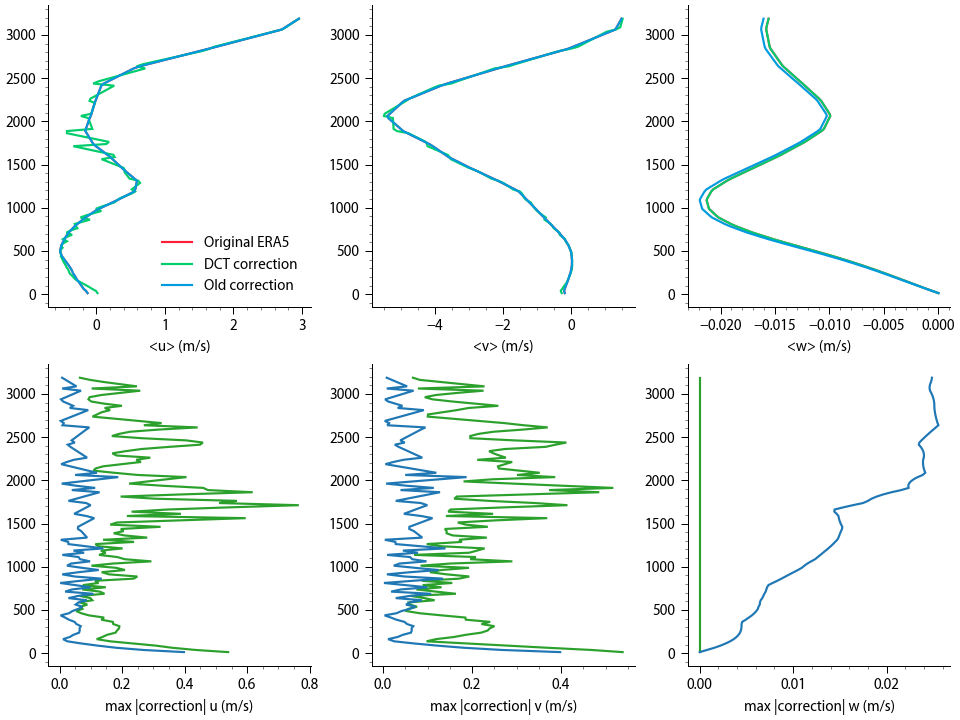

In [12]:
plt.figure(figsize=(8,6), layout='constrained')

plt.subplot(231)
plt.plot(u00.mean(axis=(1,2)), z, label='Original ERA5')
plt.plot(u11.mean(axis=(1,2)), z, label='DCT correction')
plt.plot(u22.mean(axis=(1,2)), z, label='Old correction')
plt.legend()
plt.xlabel('<u> (m/s)')

plt.subplot(232)
plt.plot(v00.mean(axis=(1,2)), z)
plt.plot(v11.mean(axis=(1,2)), z)
plt.plot(v22.mean(axis=(1,2)), z)
plt.xlabel('<v> (m/s)')

plt.subplot(233)
plt.plot(w00.mean(axis=(1,2)), z)
plt.plot(w11.mean(axis=(1,2)), z)
plt.plot(w22.mean(axis=(1,2)), z)
plt.xlabel('<w> (m/s)')

plt.subplot(234)
plt.plot(np.abs(u00-u11).max(axis=(1,2)), z, color='tab:green')
plt.plot(np.abs(u00-u22).max(axis=(1,2)), z, color='tab:blue')
plt.xlabel('max |correction| u (m/s)')

plt.subplot(235)
plt.plot(np.abs(v00-v11).max(axis=(1,2)), z, color='tab:green')
plt.plot(np.abs(v00-v22).max(axis=(1,2)), z, color='tab:blue')
plt.xlabel('max |correction| v (m/s)')

plt.subplot(236)
plt.plot(np.abs(w00-w11).max(axis=(1,2)), z, color='tab:green')
plt.plot(np.abs(w00-w22).max(axis=(1,2)), z, color='tab:blue')
plt.xlabel('max |correction| w (m/s)')

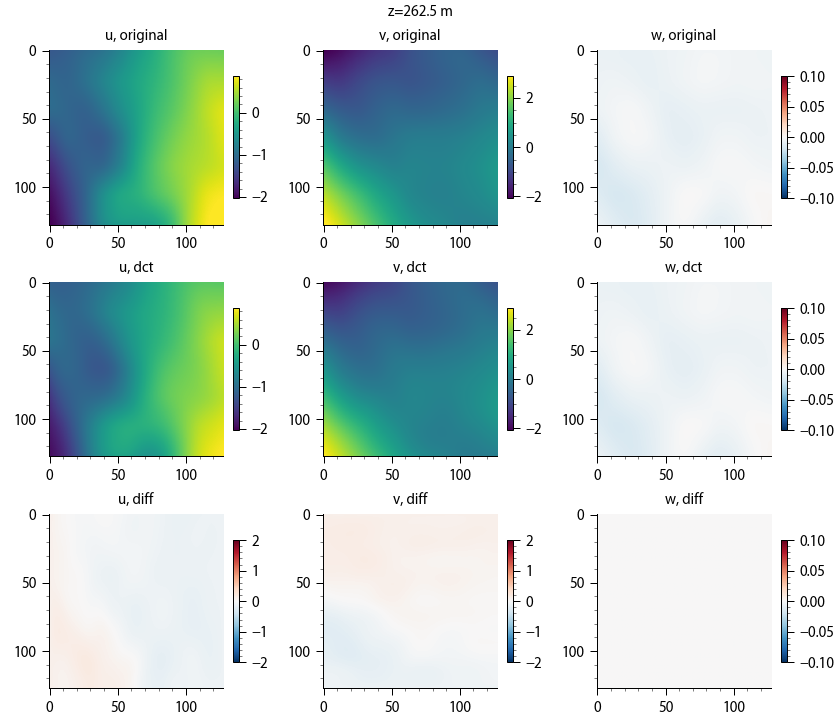

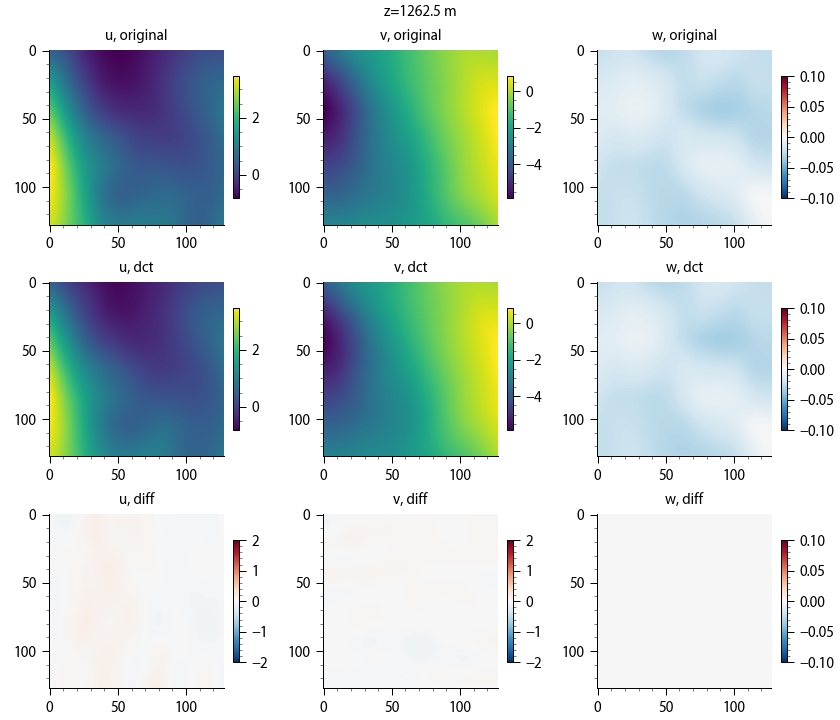

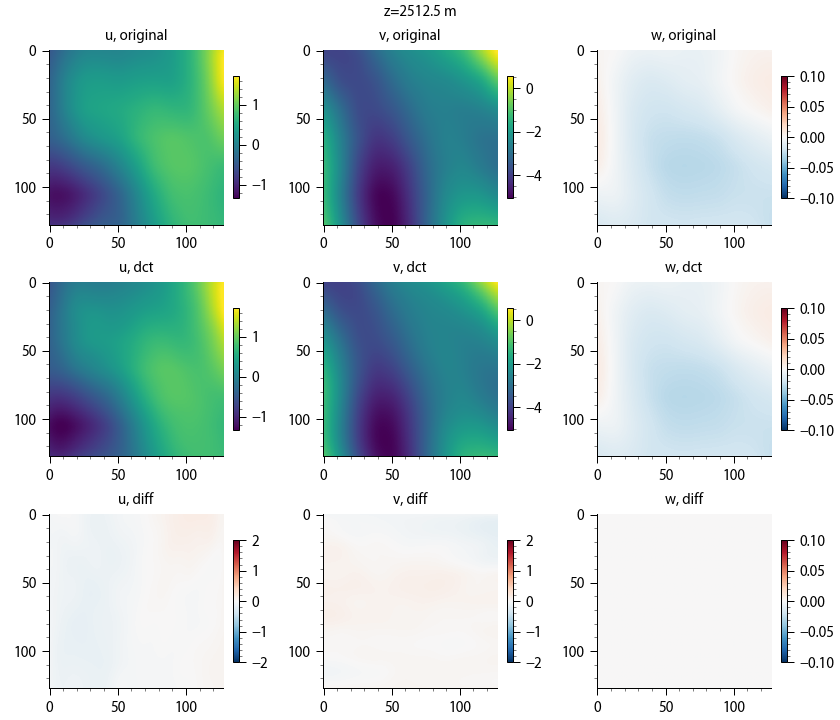

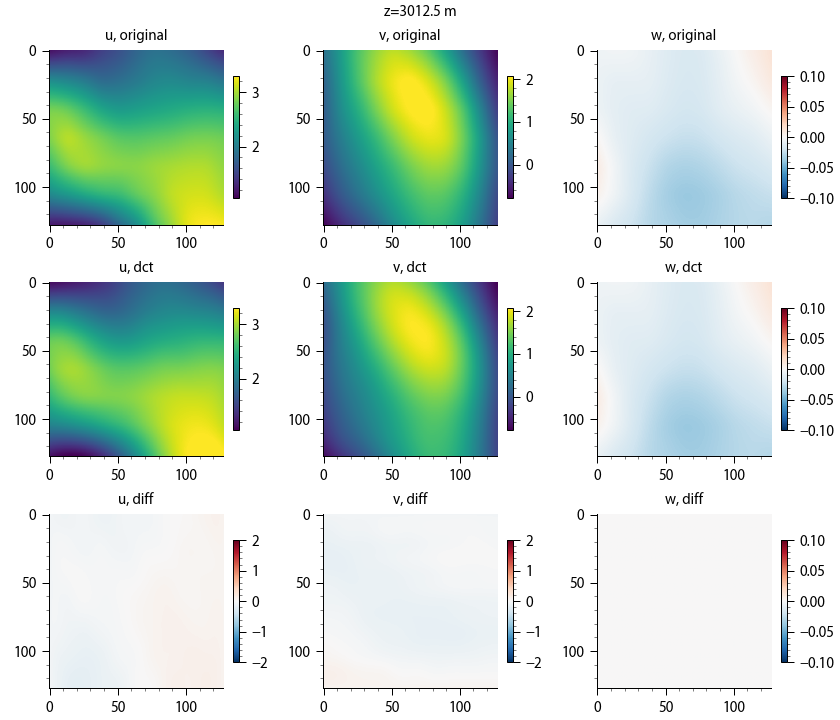

In [13]:
for k in (10, 50, 100, 120):

    vmm = 0.1
    shrink = 0.7

    vmin_u = min(u00[k].min(), u11[k].min())
    vmax_u = min(u00[k].max(), u11[k].max())
    vmin_v = min(v00[k].min(), v11[k].min())
    vmax_v = min(v00[k].max(), v11[k].max())
    vmin_w = min(w00[k].min(), w11[k].min())
    vmax_w = min(w00[k].max(), w11[k].max())

    plt.figure(figsize=(7,6), layout='constrained')
    plt.suptitle(rf'z={z[k]} m')

    plt.subplot(331)
    plt.title('u, original')
    plt.imshow(u00[k,:,:], vmin=vmin_u, vmax=vmax_u)
    plt.colorbar(shrink=shrink)

    plt.subplot(332)
    plt.title('v, original')
    plt.imshow(v00[k,:,:], vmin=vmin_v, vmax=vmax_v)
    plt.colorbar(shrink=shrink)

    plt.subplot(333)
    plt.title('w, original')
    plt.imshow(w00[k,:,:], vmin=-vmm, vmax=vmm, cmap=plt.cm.RdBu_r)
    plt.colorbar(shrink=shrink)

    plt.subplot(334)
    plt.title('u, dct')
    plt.imshow(u11[k,:,:], vmin=vmin_u, vmax=vmax_u)
    plt.colorbar(shrink=shrink)

    plt.subplot(335)
    plt.title('v, dct')
    plt.imshow(v11[k,:,:], vmin=vmin_v, vmax=vmax_v)
    plt.colorbar(shrink=shrink)

    plt.subplot(336)
    plt.title('w, dct')
    plt.imshow(w11[k,:,:], vmin=-vmm, vmax=vmm, cmap=plt.cm.RdBu_r)
    plt.colorbar(shrink=shrink)

    plt.subplot(337)
    plt.title('u, diff')
    plt.imshow(u11[k,:,:] - u00[k,:,:], vmin=-2, vmax=2, cmap=plt.cm.RdBu_r)
    plt.colorbar(shrink=shrink)

    plt.subplot(338)
    plt.title('v, diff')
    plt.imshow(v11[k,:,:] - v00[k,:,:], vmin=-2, vmax=2, cmap=plt.cm.RdBu_r)
    plt.colorbar(shrink=shrink)

    plt.subplot(339)
    plt.title('w, diff')
    plt.imshow(w11[k,:,:] - w00[k,:,:], vmin=-vmm, vmax=vmm, cmap=plt.cm.RdBu_r)
    plt.colorbar(shrink=shrink)